## Imports & Setup

In [226]:
# DO NOT DELETE THIS CELL
# Load useful libraries
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import sys
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import Accuracy

# Plotting libraries
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(font_scale=1.5)

# utility imports
import importlib

In [227]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [228]:
import requests
from IPython.core.display import HTML, display
from IPython.display import Image
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Mount Google Drive

In [229]:
if 'google.colab' in str(get_ipython()):
  # Running in Google Colab.
  # 1. Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # 2. Install a few dependencies
  !pip install --upgrade tensorflow-addons tf_keras_vis

  # 3. Make sure we can find the data
  data_dir = "/content/drive/MyDrive/cs109b/project/data/"
else:
  # 1. Set the data dir for local development
  data_dir = "../r1.0.0/"

## Dataset & tools download

In [230]:
# ##################################################
# # Code borrowed from CS109b assignment notebooks #
# #            (with mild tweaks)                  #
# ##################################################

# def download_dataset(    
#     url, 
#     filename,
#     filepath,
#     dirname,
#     dirpath,    
#     chunk_size=1204,
#     overwrite=False,
# ):
#     """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
#     # Do not download if data already exists and overwrite==False
#     if not overwrite and os.path.isdir(dirpath):
#         print(
#             "Congratulations...the dataset already exists "
#             "locally!\nNo new downloads are required :o)\n"
#         )
#     # Download and extract dataset if it doesn't already exist
#     else:
#         print(f"Downloading dataset to {filepath}\n")

#         with requests.get(url, stream=True) as r:
#             chunk_size = 1024
#             length = int(r.headers['content-length'])
#             print(f"...downloading a {(length/1e9):.2f} GB file."
#                 "This is going to take a while!"
#             )
#             time.sleep(0.5)
#             with open(filepath, 'wb') as f:
#                 for chunk in tqdm.tqdm(
#                     r.iter_content(chunk_size=chunk_size),
#                     total=int(length/chunk_size),
#                     unit="KB"
#                 ):
#                     f.write(chunk)

#         print(f"...{filename} download complete :o)")
#         if not os.path.isdir(dirpath):
#             os.makedirs(dirpath)

#         print(
#             f"...extracting {filename}. \n"
#         )

#         with zipfile.ZipFile(filepath, 'r') as zipobj:
#             zipobj.extractall(dirpath)

#         print(f"The dataset has been extracted to: \n\n\t{dirpath}\n")            

In [231]:
# %%time
# working_dir = pathlib.Path().absolute()
# os.chdir(working_dir)

# # dataset params
# dataset_url = "https://fusion-360-gallery-dataset.s3-us-west-2.amazonaws.com/reconstruction/r1.0.0/r1.0.0.zip"
# filename = "r1.0.0.zip"
# dirname = f"{data_dir}reconstruction"
# dirpath = os.path.join(working_dir, dirname)
# filepath = os.path.join(working_dir, filename)

# download_dataset(dataset_url, filename, filepath, data_dir, dirpath)

# # Final locatioin of the dataset
# dataset_path = f"../r1.0.0/"
# train_test_file = f"{dataset_path}train_test.json"

In [232]:
dataset_path = data_dir
train_test_file = f"{dataset_path}train_test.json"

In [233]:
def download_file(url: str, filepath: str):
  dir = os.path.dirname(filepath)
  if not os.path.isdir(dir):
      os.makedirs(dir)

  with requests.get(url, stream=True) as r:      
      with open(filepath, 'wb') as f:
        f.write(r.content)

tools_path = f"{data_dir}tools/"
download_file(
  "https://raw.githubusercontent.com/AutodeskAILab/Fusion360GalleryDataset/master/tools/sketch2image/sketch_plotter.py",
  f"{tools_path}sketch_plotter.py"
)      

# Append tools directory to path so we can import from it
sys.path.append(os.path.abspath(tools_path))

In [234]:
def get_sketches(path):
  """ Returns a list of json objects representing sketches"""
  # Load up the data file
  with open(metadata_file, 'r') as f:
    data_json = json.load(f)
  
  # The file will contain multiple sketches, so pull the ids ...
  entity_ids = list(data_json['entities'].keys())

  # not all entities will be sketches, so filter ... 
  sketch_ids = [id for id in entity_ids if data_json['entities'][id]["type"] == "Sketch"]

  return [data_json['entities'][id] for id in sketch_ids]

def draw_sketches(sketches):
  """ Draws the given sketches """
  for sketch in sketches:
    plotter = SketchPlotter(sketch)
    try:
      plotter.create_drawing()
    except KeyError:
      continue

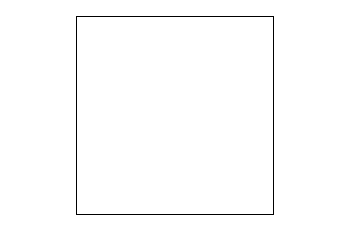

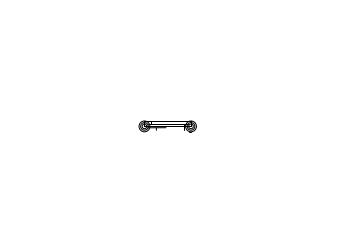

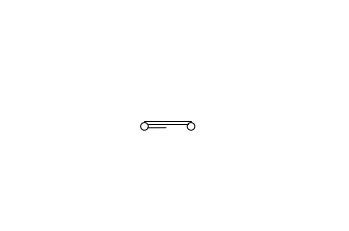

In [235]:
from sketch_plotter import SketchPlotter
import json

# Load train/test json file 
with open(train_test_file, 'r') as f:
  train_test_json = json.load(f)

# Randomly select some ids from the training set
n = 2
random_train_ids = np.random.choice(train_test_json['train'], n)

for id in random_train_ids:
  metadata_file = f"{dataset_path}reconstruction/{id}.json"
  sketches = get_sketches(metadata_file)
  draw_sketches(sketches=sketches)

## Summary Statistics

In [236]:
# Iterate through json files in reconstruction folder (training set only)
train_test_file = f"{dataset_path}train_test.json"

# Return lists containing the train and test filenames
def get_json_train_test(file):
    training_list = []
    test_list = []
    with open(file, 'r') as f:
        train_test_json = json.load(f)
        training_list = train_test_json['train']
        test_list = train_test_json['test']
    return training_list, test_list

# Return dataframe with summaries from json files
def summary_df(json_list):
    operation_dict = {'NewBodyFeatureOperation':       0,
                      'JoinFeatureOperation':          1,
                      'CutFeatureOperation':           2,
                      'IntersectFeatureOperation':     3
                     }
    
    dict_to_df = {'parent_project':       [],
                  'component_index':      [],
                  'part_uuid':            [],
                  'num_sketches':         [],
                  'num_extrudes':         [],
                  'operation_order':      [],
                  'operation_order_nums': [],
                  'num_bodies':           []
                 }
    
    for file in json_list:
        filepath = f"{dataset_path}/reconstruction/{file}.json"
        try:
            with open(filepath, 'r') as f:
                json_file = json.load(f)
                dict_to_df['parent_project'].append(json_file['metadata']['parent_project'])
                dict_to_df['component_index'].append(json_file['metadata']['component_index'])
                dict_to_df['part_uuid'].append(file)
                entities = json_file['entities']
                num_sketches = 0
                num_extrudes = 0
                operations = []
                for entity in entities:
                    entity_type = json_file['entities'][entity]['type']
                    num_sketches += 1 if entity_type == 'Sketch' else 0
                    num_extrudes += 1 if entity_type == 'ExtrudeFeature' else 0
                    if entity_type == 'ExtrudeFeature':
                        operation = json_file['entities'][entity]['operation']
                        operations.append(operation)
                dict_to_df['num_sketches'].append(num_sketches)
                dict_to_df['num_extrudes'].append(num_extrudes)
                dict_to_df['operation_order'].append(operations)
                dict_to_df['operation_order_nums'].append([operation_dict[a] for a in operations])
                dict_to_df['num_bodies'].append(json_file['properties']['body_count'])
                
        except FileNotFoundError:
            print("{} not found".format(filepath))
    df = pd.DataFrame(dict_to_df)
    return df

In [237]:
training_list, test_list = get_json_train_test(train_test_file)

In [238]:
df_summary = summary_df(training_list)

/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/

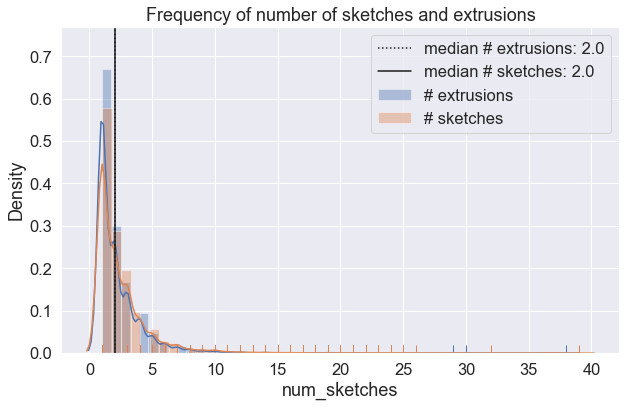

In [239]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df_summary['num_extrudes'], label='# extrusions', rug=True)
sns.distplot(df_summary['num_sketches'], label='# sketches', rug=True)
ax.set(title='Frequency of number of sketches and extrusions')
ax.axvline(df_summary['num_extrudes'].median(), 
           label='median # extrusions: {}'.format(df_summary['num_extrudes'].median()), color='k', linestyle=':')
ax.axvline(df_summary['num_sketches'].median(), 
           label='median # sketches: {}'.format(df_summary['num_sketches'].median()),color='k')
ax.legend()
plt.show()

/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


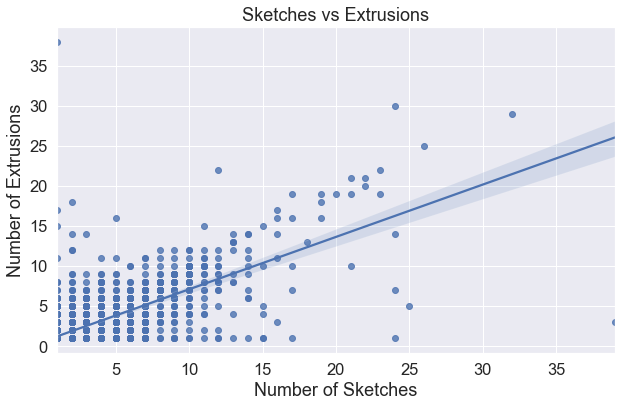

In [240]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(df_summary['num_sketches'], df_summary['num_extrudes'])
ax.set(xlabel='Number of Sketches', ylabel='Number of Extrusions',
      title='Sketches vs Extrusions')
plt.show()

[Text(0.5, 0, 'operation step'),
 Text(0, 0.5, 'operation step type'),
 Text(0.5, 1.0, 'Progression of operation step type through number of operations')]

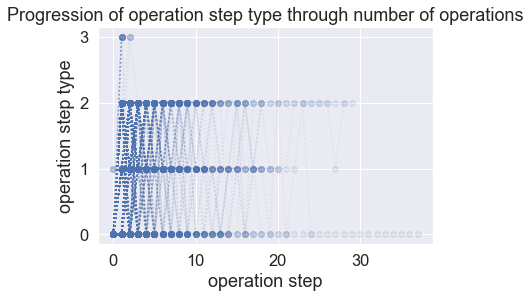

In [241]:
fig, ax = plt.subplots()
for i in range(df_summary.shape[0]):
    ax.plot(df_summary.iloc[i]['operation_order_nums'],
            marker='o', linestyle=':', alpha=0.1, color='b')
ax.set(xlabel='operation step', ylabel='operation step type',
      title='Progression of operation step type through number of operations')

In [242]:
# Calculate delta between number of scketches and number of extrude steps 
# in a model as a indicator of consiceness in the training set
df_summary['extr_sketch'] = df_summary['num_extrudes'] - df_summary['num_sketches']
df_sorted = df_summary.sort_values('extr_sketch', ascending=False)

df_sorted.head(5)

,parent_project,component_index,part_uuid,num_sketches,num_extrudes,operation_order,operation_order_nums,num_bodies,extr_sketch
4149,126572_a2d6f794,0,126572_a2d6f794_0000,1,38,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,37
2343,146291_6b0c8db3,2,146291_6b0c8db3_0002,1,17,"[NewBodyFeatureOperation, JoinFeatureOperation...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,16
5232,142074_34e02b6d,0,142074_34e02b6d_0000,2,18,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18,16
6802,126907_8c612811,0,126907_8c612811_0000,1,15,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",15,14
6665,43467_eb9b64c2,0,43467_eb9b64c2_0000,2,14,"[NewBodyFeatureOperation, CutFeatureOperation,...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",1,12


126572_a2d6f794_0000


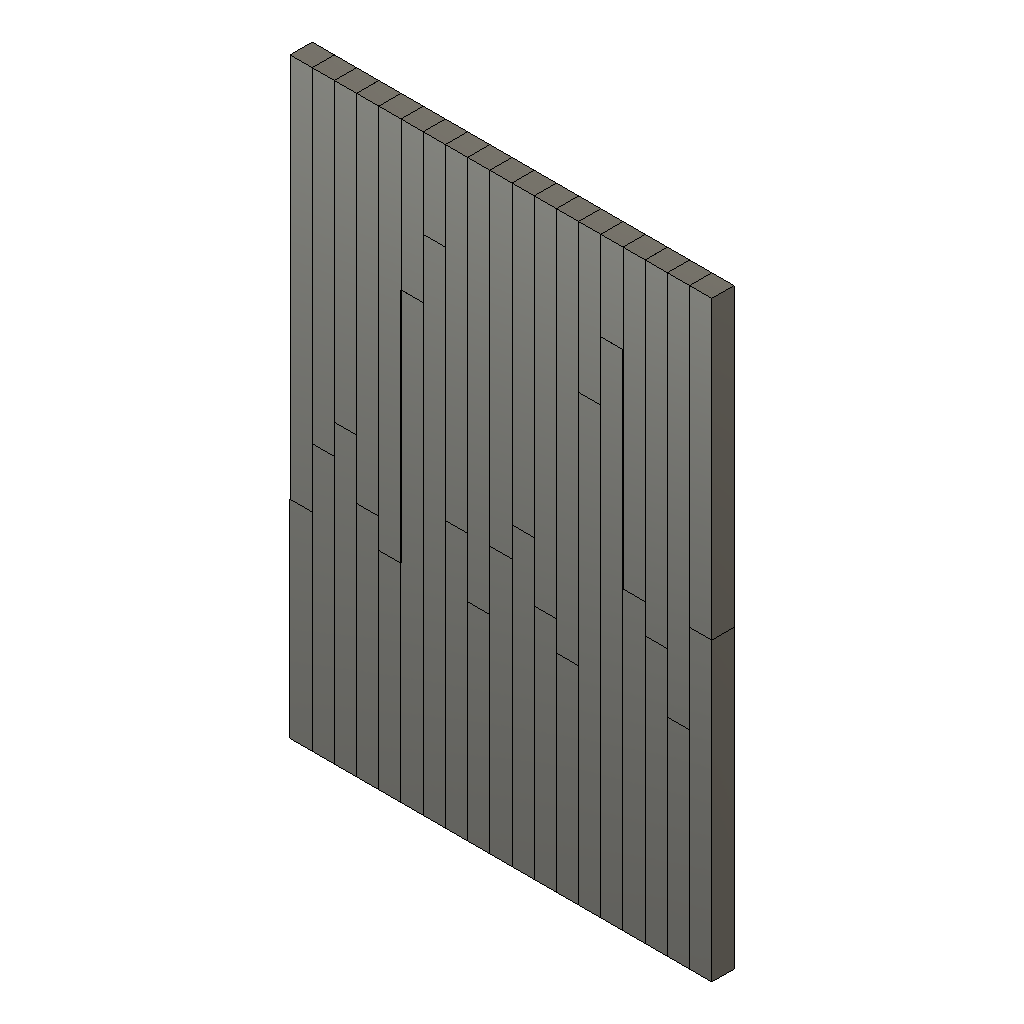

In [243]:
img_file = df_sorted.iloc[0]['part_uuid']
print(img_file)
Image(f"{dataset_path}/reconstruction/{img_file}.png")

/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='extr_sketch', ylabel='Density'>

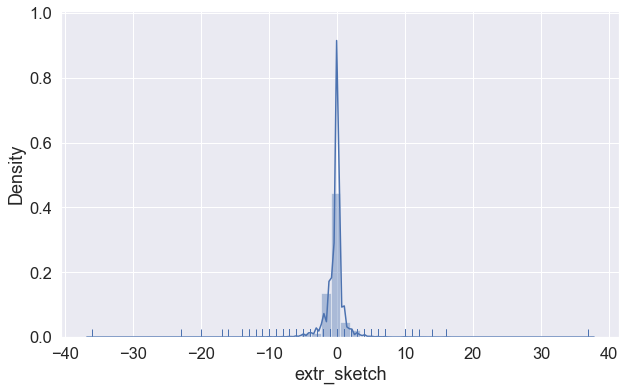

In [244]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df_summary['extr_sketch'], rug=True)

/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='extr_sketch', ylabel='Density'>

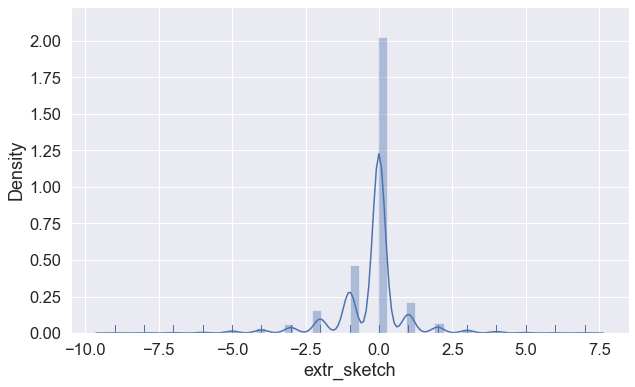

In [245]:
df_cleaned = df_summary.loc[(df_summary['extr_sketch'] <= 9) &
                           (df_summary['extr_sketch'] >= -9)].copy()
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df_cleaned['extr_sketch'], rug=True)

In [246]:
# Sort dataframe by number of bodies in the model
df_sorted_bodies = df_summary.sort_values(by='num_bodies', ascending=False)
df_sorted_bodies.head(775).reset_index()

,index,parent_project,component_index,part_uuid,num_sketches,num_extrudes,operation_order,operation_order_nums,num_bodies,extr_sketch
0,4149,126572_a2d6f794,0,126572_a2d6f794_0000,1,38,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,37
1,5730,95620_940f6521,0,95620_940f6521_0000,2,2,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0]",33,0
2,3064,125745_cf468448,0,125745_cf468448_0000,1,1,[NewBodyFeatureOperation],[0],31,0
3,2095,34982_fd1e87ff,0,34982_fd1e87ff_0000,19,19,"[NewBodyFeatureOperation, CutFeatureOperation,...","[0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...",19,0
4,5232,142074_34e02b6d,0,142074_34e02b6d_0000,2,18,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18,16
...,...,...,...,...,...,...,...,...,...,...
770,2194,113191_87565693,2,113191_87565693_0002,2,4,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 1, 0]",2,2
771,3865,79695_fd8bae0e,0,79695_fd8bae0e_0000,6,6,"[NewBodyFeatureOperation, CutFeatureOperation,...","[0, 2, 2, 2, 0, 1]",2,0
772,411,23437_a9fd0e5c,0,23437_a9fd0e5c_0000,4,4,"[NewBodyFeatureOperation, NewBodyFeatureOperat...","[0, 0, 2, 2]",2,0
773,4711,115524_4490925e,0,115524_4490925e_0000,2,1,[NewBodyFeatureOperation],[0],1,-1


125745_cf468448_0000


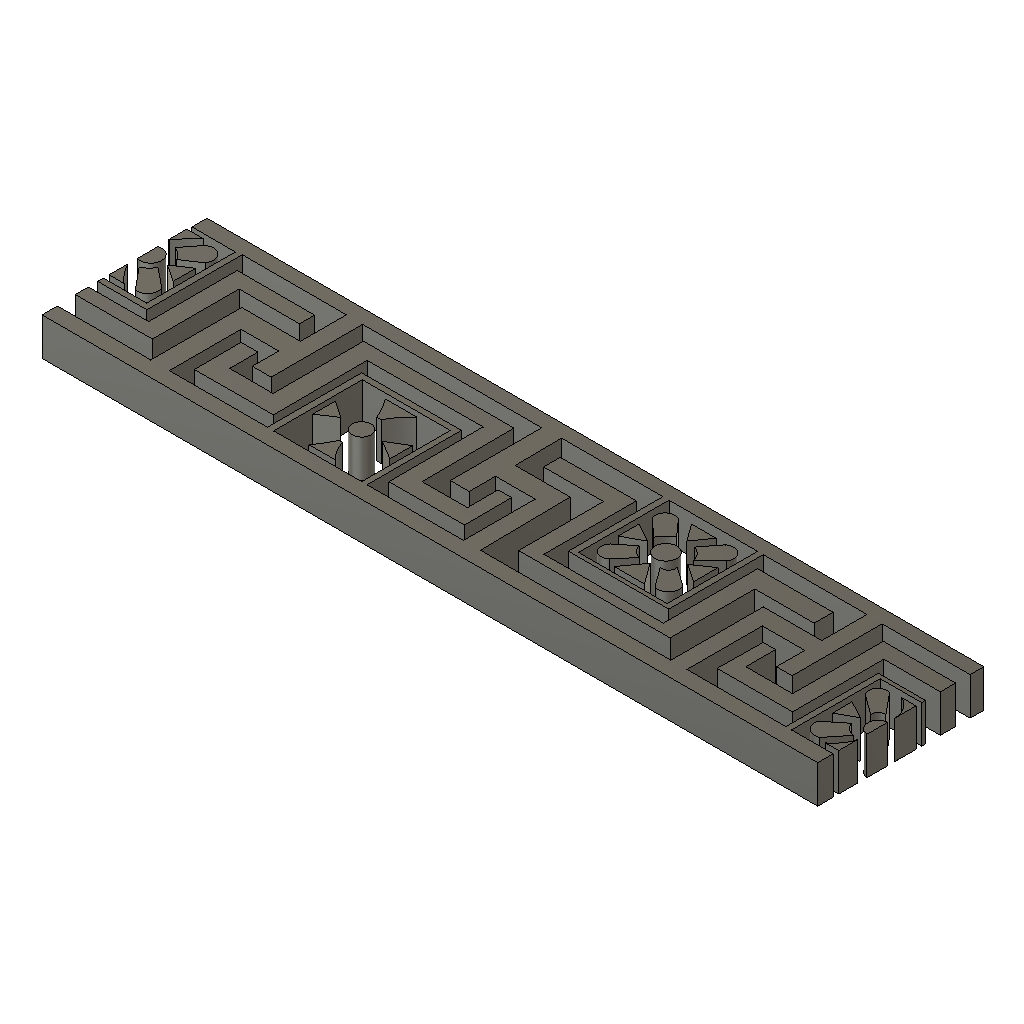

In [247]:
img_file = df_sorted_bodies.iloc[2]['part_uuid']
print(img_file)
Image(f"{dataset_path}/reconstruction/{img_file}.png")

/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


[(0.0, 5.0)]

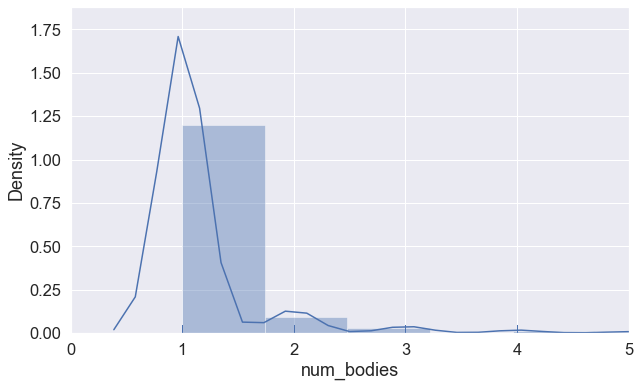

In [248]:
# Truncated historgram of number of bodies per model
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df_summary['num_bodies'], rug=True)
ax.set(xlim=(0, 5))

## Create cleaned json file for train and test split

In [249]:
# Create cleaned train set
df_train = df_summary.loc[(df_summary['extr_sketch'] < 10)
                          & (df_summary['num_bodies'] == 1)].copy()

# Create cleaned test set
df_test = summary_df(test_list)
df_test = df_test.loc[(df_test['num_bodies'] == 1)].copy()

# Make into dictionary for conversion to json
train_list = list(df_train['part_uuid'])
test_list = list(df_test['part_uuid'])

new_split_list = {'train': train_list,
                 'test': test_list}
# Save as json
with open("train_test_cleaned.json", "w") as write_file:
    json.dump(new_split_list, write_file, indent=4)